### Exploring the annotated data.

In [ ]:
from datasets import load_dataset, disable_caching
import pandas as pd
import os
from tqdm.auto import tqdm

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
shader20k_files = os.listdir("./data/annotated")
# print(shader20k_files)
shader20k_files = [f"./data/annotated/{f}" for f in shader20k_files if f.startswith("20k")]
# ds = load_dataset("json", data_dir="./data/annotated", download_mode="force_redownload", cache_dir=None)
ds = load_dataset("json", data_files=shader20k_files, download_mode="force_redownload", cache_dir=None)
# ds = load_dataset("json", data_dir="./data/annotated_test/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

In [ ]:
# fewer than 6k unique authors in shaders20k
df["author"].nunique()

In [ ]:
# this is just from the 20k shaders dataset
df["date"].dt.year.value_counts().sort_index()#.plot(kind="bar")

In [ ]:
#redo the df

df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
#

In [ ]:
df["test"].value_counts().head(10)

In [ ]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))

In [ ]:
# filtering down the dataset and keeping track of the numbers
print(ds["train"].unique("license"))
# filter permissive licenses
filtered_ds = ds["train"]
num_all = len(filtered_ds)
print(f"{num_all=}")
filtered_ds = filtered_ds.filter(lambda x: x["published"] == "Public API") # only take shaders published to the API
num_public_api = len(filtered_ds)
print(f"{num_public_api=}")
filtered_ds = filtered_ds.filter(lambda x: x["license"] in permissive_list + ["CC-BY-NC-SA-3.0"]) # permissive or base case(not actually permissive...) what about those AND and OR classifications?
num_permissive = len(filtered_ds)
print(f"{num_permissive=}")
filtered_ds = filtered_ds.filter(lambda x: x["test"] == "ok") # ok means it actually runs, valid was just that naga didn't error... but this also has issues
num_working = len(filtered_ds)
print(f"{num_working=}")
filtered_ds

In [ ]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

In [ ]:
def plot_per_month(column, stretched=False, data=None, **kwargs):
    if data is None:
        # lazy default case, to avoid name errror when not running cells above
        data = df
    feature_df = data["date"].groupby([data["date"].dt.to_period("M"), data[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)

def plot_per_year(column, stretched=False, data=None, **kwargs):
    if data is None:
        # lazy default case, to avoid name errror when not running cells above
        data = df
    feature_df = data["date"].groupby([data["date"].dt.to_period("Y"), data[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
# plot_per_month("license", True, legend=False)

In [ ]:
plot_per_month("published", False)

In [ ]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

In [ ]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

In [ ]:
df["num_inputs"] = df["image_inputs"].apply(len)
plot_per_month("num_inputs", stretched=False, legend=True)

In [ ]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][19616],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

In [ ]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids, dates = [],[],[],[]
    for code, func_bytes, shader_id, shader_date in zip(batch["image_code"], batch["functions"], batch["id"], batch["date"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
            dates.append(shader_date)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            "date": dates,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = filtered_ds.map(split_functions, batched=True, remove_columns=filtered_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

In [ ]:
func_df = func_ds.to_pandas()
func_df["date"] = pd.to_datetime(func_ds["date"], unit="s") #didn't copy correctly?
func_df.head() 

In [ ]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
# func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both... and 150 for valid shaders only.

In [ ]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

In [ ]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# indicator where the docstring is just something commented out - not helpful instructions.
func_df["docstring"].str.endswith(";").sum()

In [ ]:
# the comment is just a link to some website/reference? although sometimes it's a bunch of natural langauge too?
print(func_df["comment"].str.contains("https://").sum())
print(func_df["comment"].str.contains("www.").sum())

In [ ]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
num_both= len(both_df)
print(f"{num_both=}")
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

In [ ]:
# this step can timeout/hang -.-
# step 2. if code runs without the function.
# takes ~1.4 minutes at home.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:] #TODO: this needs to be done in bytes -.-
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

In [ ]:
# down select the only the needed and working examples.
print(len(both_df))
both_df = both_df.loc[both_df["needed"]]
num_needed = len(both_df)
print(f"{num_needed=}")

In [ ]:
from datasets import Dataset

both_df.loc[:,"input_both"] = both_df["comment"] + both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_comment"] = both_df["comment"] + both_df["header"]
both_df.loc[:,"input_docstring"] = both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_none"] = both_df["header"]
print(both_df.shape)
print(both_df["input_both"].nunique())
# remove the duplicates
both_df.drop_duplicates("input_both", inplace=True)
experiment_ds = Dataset.from_pandas(both_df)
experiment_ds

In [ ]:
# this pushes the dataset to the hub, uncomment with care!
# experiment_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", private=False, commit_message="v0.2 filtered down to 257 examples, ensures working and Public+API")

In [ ]:
# making a river plot (sankey diagram) of all out filtering steps
# keeping track of number of functions and then in backets (number of shader programs)
# filtering steps are in this order:
# 1. on shader programs: published, license, test,
# 2. on functions: comment+docstring, needed, deduplicate

program_filter_steps = [num_all, num_public_api, num_permissive, num_working]
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
plt.figure(figsize=(20,10))
plot = Sankey(head_angle=135, ax=plt.gca(), offset=-5000, unit=" shaders")
# easily add a secondary data source?
plot.add(flows=[-num_all], labels=["shaders20k"], pathlengths=[9000])
plot.add(flows=[num_all, -num_public_api, -(num_all-num_public_api)], patchlabel="published", labels=[None,"Published+API", "public/private"], pathlengths=[5000, 1000, 0], orientations=[0,0,-1], prior=0, connect=(0,0), trunklength=5000)
plot.add(flows=[num_public_api, -num_permissive, -(num_public_api-num_permissive)], labels=[None,"permissive", "copyright, copyleft"], pathlengths=[1000, 6000, (num_all-num_public_api)], orientations=[0,0,-1], prior=1, connect=(1,0), trunklength=5000)
plot.add(flows=[num_permissive, -num_working, -(num_permissive-num_working)], labels=[None, "working", "error"], pathlengths=[2000, 8000, (num_all-num_permissive)], orientations=[0,0,-1], prior=2, connect=(1,0))

# no we switch to function level
plot.add(flows=[num_working, -len(func_df)],prior=3, connect=(1,0),orientations=[1], patchlabel="function parsing", labels=[None, "functions"], pathlengths=[1000, 2000]) #need to change unit?
# add function with comment and docstring = 329
plot.add(flows=[len(func_df), -xtab.iloc[1,1], -xtab.iloc[0,0], -xtab.iloc[0,1], -xtab.iloc[1,0]],prior=4, connect=(1,0),orientations=[0,0,-1,-1,-1], labels=[None,"both", "none", "docstring","comment"], pathlengths=[3000, 0, 0, 0, 0])
# only needed functions = 318
plot.add(flows=[xtab.iloc[1,1], -318, -11],prior=5, connect=(1,0),orientations=[0, 0, -1], labels=[None,"needed", "unneeded"], pathlengths=[5000, 5000, 10000])
# deduplicated = 257
plot.add(flows=[318, -len(both_df), -(318-len(both_df))],prior=6, connect=(1,0),orientations=[0, 0, -1], labels=[None, "unique", "duplicates"], pathlengths=[4000, 2000, 10000])

# TODO: fancy this up - maybe figure out a scale
# TODO: refactor this all into a function or generator to make the syntax less horrible.
plot.finish()
plt.savefig("../Thesis/report/texs/charts/data_filtering.png")
plt.show()

In [ ]:
# plot unique headers per month
# only looking at our "permissive" subset.
# tag every function as unique until it shows up twice (we use the header, iterate by time)
for i, row in tqdm(func_df.iterrows()):
    if func_df.loc[:i,"header"].eq(row["header"]).sum() > 1:
        func_df.at[i, "unique_header"] = False
    else:
        func_df.at[i, "unique_header"] = True

plot_per_month("unique_header", stretched=False, data=func_df, legend=True)

# Extension with API data

### only downloaded years 2020 till 2023 for now. It takes around 1 hour per year....

there is ~ 32k shaders on the API.
we need to apply a few extra filters and then join them with the above...

In [ ]:
import os 
import jsonlines
import datasets
import pandas as pd


# awful code snippet pending https://github.com/huggingface/datasets/issues/7092 to use load_dataset instead (with both parts maybe).
api_files = os.listdir("./data/annotated/api")

api_files = [f"./data/annotated/api/{f}" for f in api_files]

api_file_contents = []
for f in api_files:
    with jsonlines.open(f) as reader:
        for obj in reader:
            api_file_contents.append(obj)

ds_api = datasets.Dataset.from_list(api_file_contents)

df_api = ds_api.to_pandas()

df_api["date"] = pd.to_datetime(df_api["date"].astype(int), unit="s")

num_all = len(df_api)
print(f"{num_all=}")

In [ ]:

# Filter 1: only shaders that are single pass (as in they don't have buffer passes etc)
# TODO: sound could be allowed, since it doesn't impact the image.

# TODO: maybe use common_code as that is trivially to combine?
print(f'number of shaders with common code={df_api.loc[df_api["common_code"] != ""].shape[0]}')
other_passes = [col for col in df_api.columns if col.endswith("_code") and col not in ("image_code")] #, "common_code", "souncd_code"

df_api = df_api[(df_api.loc[:,other_passes] == "").all(axis=1)]
num_single_pass = len(df_api)
print(f"{num_single_pass=}")


In [ ]:
# Filter 2: only shaders that don't require inputs (for the image_pass which is left now)
# df_api["image_inputs"].apply(len).value_counts() # -> there is quite something
# TODO: maybe only some channel_types are bad... perhaps keep the ones we support (.complete)

df_api = df_api[df_api["image_inputs"].apply(len) == 0]
num_no_inputs = len(df_api)
print(f"{num_no_inputs=}")

In [ ]:
# Filter 3: overlap with the shaders20k data.
# we keep the "older" variant from the shaders20k dataset because that is static and won't change.

ids_20k = set(df["id"])

df_api = df_api[~df_api["id"].isin(ids_20k)]
num_new = len(df_api)
print(f"{num_new=}")

### combine and use similar filters as above...

In [1]:
# puttint it all together
import os
import jsonlines
import pandas as pd
import requests


def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    return pd.DataFrame(lines)


def filter_public_api(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are published to the API.
    """
    # TODO: Publish API shouldn't be in raw or annotated, this needs to be fixed in both datahalves.
    return dataframe[dataframe["published"].isin(["Public API", 3])]


def filter_licenses(dataframe: pd.DataFrame, keep_base=False, **kwargs) -> pd.DataFrame:
    """
    only keep permissive licenses.
    """
    permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
    permissive_list = [l.lower() for l in permissive_list]
    #TODO: figure out cases with AND and OR in the detection.
    if keep_base:
        permissive_list.append("CC-BY-NC-SA-3.0")
    return dataframe[dataframe["license"].isin(permissive_list)]


def filter_single_pass(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are single pass.
    """
    other_passes = [col for col in dataframe.columns if col.endswith("_code") and col not in ("image_code")]
    #TODO: consider keeping sound_code and common_code (the later one needs to be prepended to the image_code)
    return dataframe[(dataframe.loc[:,other_passes] == "").all(axis=1)]


def filter_no_inputs(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that don't require inputs.
    to be used after you filtered for single pass shaders.
    """
    # TODO: consider keeping some channel_types
    return dataframe[dataframe["image_inputs"].apply(len) == 0]

#TODO: inspect if this is the case
def filter_words(dataframe: pd.DataFrame, words=["test", "bug"], **kwargs) -> pd.DataFrame:
    """
    Drop all shaders that contain works like "test", "debug", "ai", "chatGPT", in the title, description or tags.
    """
    for word in words:
        dataframe = dataframe[~dataframe["name"].str.contains(word, case=False)]
        dataframe = dataframe[~dataframe["description"].str.contains(word, case=False)]
        # dataframe = dataframe[~dataframe["tags"]" ".join().str.contains(word, case=False)] # can't do string opeerations on list of tags.

    return dataframe


def filter_working(dataframe: pd.DataFrame, untested=False, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are working.
    Note: the idea of using `untested=True` is to first run all filters and just get a list of IDs, to then test these.
    Testing is slow and should therefore be only annotated where it's needed.
    """

    # TODO: testing needs to really work before we can rely on this
    drop_values = ["error", "panic", "timeout", "timedout", "valid", "untested"]
    keep_values = ["ok"]
    if untested:
        drop_values.remove("untested")
        keep_values.append("untested")
    return dataframe[dataframe["test"].isin(keep_values)]

PROGRAM_FILTERS = [filter_public_api, filter_licenses, filter_single_pass, filter_no_inputs, filter_words, filter_working]

def filter_programs(dataframe: pd.DataFrame, filters=PROGRAM_FILTERS, **kwargs) -> pd.DataFrame:
    """
    apply a series of filters and print the resulting numbers
    kwargs are passed to the filters
    untested: keep untested shaders (default: False)
    keep_base: keep the base license (default: False)
    """
    print(len(dataframe))

    # TODO: add plotting into sankey?  when plot=True
    # plot = kwargs.pop("plot", None)
    # if plot is None:
        # import matplotlib.pyplot as plt
        # from matplotlib.sankey import Sankey
        # plt.figure(figsize=(20,10))
        # plot = Sankey(head_angle=135, ax=plt.gca(), offset=-5000, unit=" shader programs")
        # # easily add a secondary data source?
        # plot.add(flows=[-len(dataframe)], labels=["datasource"], pathlengths=[9000])


    for f in filters:
        dataframe = f(dataframe, **kwargs)
        print(f"{len(dataframe)} shaderprograms remaining after {f.__name__}")
    return dataframe


def combine_datasets(base_data, add_data):
    """
    combine two datasets, keeping the base data.
    """
    ids_base = set(base_data["id"])
    return pd.concat([base_data, add_data[~add_data["id"].isin(ids_base)]])


api_df = load_data("./data/annotated/api")
s20k_df = load_data("./data/annotated")
all_combined_df = combine_datasets(s20k_df, api_df) # make this early
print(f"all combined is {len(all_combined_df)} shaders")
api_df = filter_programs(api_df, untested=False, keep_base=False)
s20k_df = filter_programs(s20k_df, untested=False, keep_base=False)

combined_df = combine_datasets(s20k_df, api_df)
combined_df["date"] = pd.to_datetime(combined_df["date"].astype(int), unit="s")
print(len(combined_df))



all combined is 27857 shaders
8235
8235 shaderprograms remaining after filter_public_api
304 shaderprograms remaining after filter_licenses
225 shaderprograms remaining after filter_single_pass
167 shaderprograms remaining after filter_no_inputs
163 shaderprograms remaining after filter_words
137 shaderprograms remaining after filter_working
19622
7263 shaderprograms remaining after filter_public_api
408 shaderprograms remaining after filter_licenses
408 shaderprograms remaining after filter_single_pass
345 shaderprograms remaining after filter_no_inputs
330 shaderprograms remaining after filter_words
276 shaderprograms remaining after filter_working
413


In [2]:
# expand to functions and then do function filters
 
from annotate import run_shader
from tqdm import tqdm

tqdm.pandas()

def expand_functions(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # TODO: likely redundant, since we keep everything... might need some cleanup instead
    cols_to_keep = ["id", "date", "image_code", "functions", "func_bytes", "author", "license"]
    #function byte indicies: start_comment, start_header, end_header, end_docstring, end_function
    func_parts = ["comment", "header", "docstring", "body"]

    # TODO: do we need the whole functions for anything downstream?
    dataframe["functions_"] = dataframe["functions"] # make a copy to keep it past explode
    func_df = dataframe.explode("functions")
    func_df.rename(columns={"functions": "func_bytes", "functions_": "functions"}, inplace=True)
    func_df.dropna(subset=["func_bytes"], inplace=True) # some shaders got not functions parsed ? -> TODO: check the tree-sitter.has_error() result?
    func_df.reset_index(inplace=True)
    for row_idx, row in func_df.iterrows():
        # print(row_idx, row)
        # break
        code = row["image_code"]
        code_bytes = bytes(code, encoding="utf-8")
        # func_bytes = row["func_bytes"]
        for idx, part in enumerate(func_parts):
            start = row["func_bytes"][idx]
            end = row["func_bytes"][idx+1]
            func_df.at[row_idx, part] = code_bytes[start:end].decode(encoding="utf-8")
        
    func_df.drop(columns=func_df.columns.difference(cols_to_keep + func_parts), inplace=True)
    # func_df["date"] = pd.to_datetime(func_df["date"].astype(int), unit="s")

    return func_df

def filter_has_context(dataframe: pd.DataFrame, context="comment", **kwargs) -> pd.DataFrame:
    """
    only keep functions that have a specific context. (not exclusive)
    context: one of "comment", "docstring", "both", "none"
    """
    # TODO: not all are implemented
    if context == "comment":
        return dataframe[dataframe["comment"] != ""]
    elif context == "docstring":
        return dataframe[dataframe["docstring"] != ""]
    elif context == "both":
        return dataframe[(dataframe["comment"] != "") & (dataframe["docstring"] != "")]
    elif context == "none":
        raise NotImplementedError(f"not implemented yet for context: {context}")
    else:
        raise ValueError(f"unknown context: {context}")

# TODO: combine construct_inp and filter_has_context into one function maybe?
def construct_inp(dataframe: pd.DataFrame, context="comment", **kwargs) -> pd.DataFrame:
    """
    adds the model_inp column based on the context.
    """
    if context == "comment":
        dataframe["model_inp"] = dataframe["comment"] + dataframe["header"]
    elif context == "docstring":
        dataframe["model_inp"] = dataframe["header"] + dataframe["docstring"]
    elif context == "both":
        dataframe["model_inp"] = dataframe["comment"] + dataframe["header"] + dataframe["docstring"]
    elif context == "none":
        dataframe["model_inp"] = dataframe["header"]
    else:
        raise ValueError(f"unknown context: {context}")
    return dataframe

def filter_length(dataframe: pd.DataFrame, max_length=2500, **kwargs) -> pd.DataFrame:
    """
    sort out function bodies that are really long. (likely machine generated)
    """
    # TODO: why chose this number?
    return dataframe[dataframe["body"].apply(len) <= max_length]

def filter_alphabetic(dataframe: pd.DataFrame, column="comment", cutoff=0.25, **kwargs) -> pd.DataFrame:
    """
    sort out functions that have an alphabetic ration above the cutoff.
    """
    return dataframe[dataframe[column].apply(lambda x: sum(c.isalpha() for c in x) / len(x)) > cutoff]

def filter_duplicates(dataframe: pd.DataFrame, sort_by="date", **kwargs) -> pd.DataFrame:
    """
    only keeps unique model_inp values. 
    sort_by specifies a column to sort by and keep the top value of. (default is "date")
    the sorting is not kept
    """
    if sort_by not in dataframe.columns:
        raise ValueError(f"unknown column to sort by: {sort_by}")
    # asceding=True and keep="first" are the defualts, meaning we keep ealier entries! 
    # if sorting my views or likes it might might sense to either set ascending=False or keep="last" (not both).
    dataframe.sort_values(by=sort_by, inplace=True, ascending=True)
    out_df = dataframe.drop_duplicates("model_inp", keep="first") #default is "keep first"
    # undo the sort
    return out_df.sort_index()

def filter_needed(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep functions that are needed. By running the shader with the function removed and seeing if it errors...
    """
    def row_needed(row):
        # print(row["id"])
        code_bytes = bytes(row["image_code"], encoding="utf-8")
        start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
        outer_bytes = code_bytes[:start_comment] + b"\n" +  code_bytes[end_function:]
        test_code = outer_bytes.decode(encoding="utf-8")
        status = run_shader(test_code)
        return status != "ok"
    dataframe["needed"] = dataframe.progress_apply(row_needed, axis=1)
    return dataframe[dataframe["needed"]]

FUNCTION_FILTERS = [filter_has_context, construct_inp, filter_length, filter_alphabetic, filter_duplicates, filter_needed]
def filter_functions(dataframe: pd.DataFrame, filters=FUNCTION_FILTERS, **kwargs) -> pd.DataFrame:
    """
    apply a series of filters and print the resulting numbers
    kwargs are passed to the filters
    """
    print(len(dataframe))

    for f in filters:
        dataframe = f(dataframe, **kwargs)
        print(f"{len(dataframe)} functions remaining after {f.__name__}")
    return dataframe

func_df = expand_functions(combined_df)
all_funcs = expand_functions(all_combined_df)
print(f"all functions from all uniuqe image passes: {len(all_funcs)}")
# func_df = filter_functions(func_df, context="comment")

# func_df = expand_functions(combined_df)
# print(len(func_df))
# func_df = filter_has_context(func_df, context="comment")
# print(len(func_df))
# func_df = construct_inp(func_df, context="comment")
# print(len(func_df)) # shouldn't change
# func_df = filter_length(func_df)
# print(len(func_df))
# func_df = filter_duplicates(func_df)
# print(len(func_df))
# func_df = filter_needed(func_df) #this step takes nearly 3 minutes on my laptop! do we know if it ever hangs?
# print(len(func_df))
# func_df["body"].apply(len).describe()
# func_df["id"].value_counts()

all functions from all uniuqe image passes: 202752


In [3]:
len(all_combined_df)

27857

<Axes: title={'center': 'top 60 return types from ~200k functions'}, xlabel='type'>

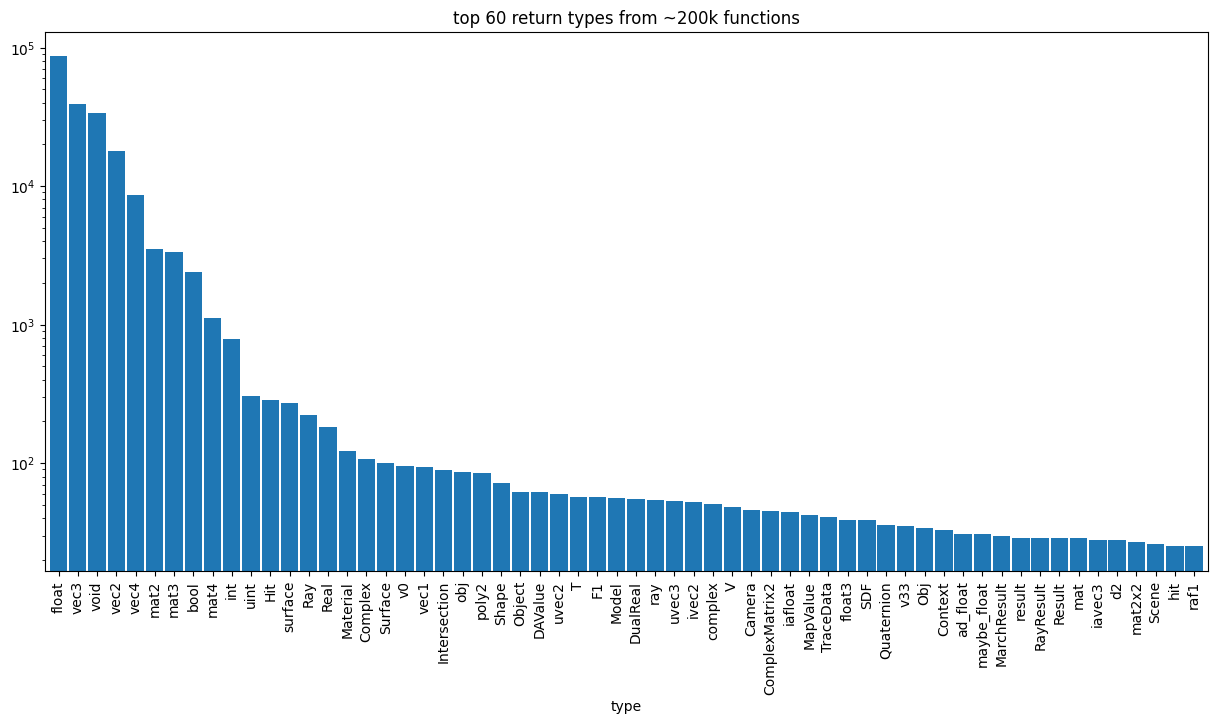

In [4]:
all_funcs["type"] = all_funcs["header"].str.split().str[0]
# all_funcs["type"].value_counts().head(30)
all_funcs["type"].value_counts().head(60).plot(kind="bar", logy=True, figsize=(15,7), title="top 60 return types from ~200k functions", width=.9)

In [5]:
# count the arg types
def get_arg_types(header):
    if "(" not in header:
        return []
    
    args = header.split("(")[1].split(")")[0].split(",")
    types = [arg.strip().removeprefix("in").removeprefix("out").strip().split()[0] for arg in args if arg.strip() != ""]
    return types

# get_arg_types(all_funcs["header"].iloc[0])

all_funcs["arg_types"] = all_funcs["header"].apply(get_arg_types)
all_funcs["arg_types"].explode().value_counts().head(30)
# all_funcs["arg_types"].explode().value_counts().head(60).plot(kind="bar", logy=True, figsize=(15,7), title="top 60 argument types from ~200k functions", width=.9)

arg_types
vec3         134495
float        112469
vec2          99950
vec4          33309
t              4724
Ray            1260
int            1159
bool           1046
const           964
sampler2D       689
uint            569
mat3            551
mat4            423
ivec2           374
ray             296
Sphere          285
Complex         263
Hit             263
Real            255
Material        255
surface         241
Ray_t           196
float3          183
uvec2           165
material        160
poly2           154
vec1            154
Light           149
//              148
Camera          137
Name: count, dtype: int64

In [6]:
all_funcs

,id,author,date,image_code,license,func_bytes,functions,comment,header,docstring,body,type,arg_types
0,4dB3DV,steverock,1393353675,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,CC-BY-NC-SA-3.0,"[1, 1, 22, 22, 71]","[[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...",,vec3 mod289(vec3 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,vec3,[vec3]
1,4dB3DV,steverock,1393353675,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,CC-BY-NC-SA-3.0,"[73, 73, 94, 94, 143]","[[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...",,vec2 mod289(vec2 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,vec2,[vec2]
2,4dB3DV,steverock,1393353675,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,CC-BY-NC-SA-3.0,"[145, 145, 166, 166, 215]","[[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...",,vec4 mod289(vec4 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,vec4,[vec4]
3,4dB3DV,steverock,1393353675,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,CC-BY-NC-SA-3.0,"[217, 217, 239, 239, 279]","[[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...",,vec4 permute(vec4 x) {,,\n return mod289(((x*34.0)+1.0)*x);\n},vec4,[vec4]
4,4dB3DV,steverock,1393353675,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,CC-BY-NC-SA-3.0,"[281, 281, 303, 303, 340]","[[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...",,vec3 permute(vec3 x) {,,\n return mod289(((x*34.0)+1.0)*x);\n},vec3,[vec3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202747,mlcfR2,Sazanami,1701409456,"void mainImage( out vec4 fragColor, in vec2 fr...",CC-BY-NC-SA-3.0,"[0, 0, 57, 107, 312]","[[0, 0, 57, 107, 312]]",,"void mainImage( out vec4 fragColor, in vec2 fr...",\n // Normalized pixel coordinates (from 0 ...,\n vec2 uv = fragCoord/iResolution.xy;\n ...,void,"[vec4, vec2]"
202748,dltfzB,ArmandB,1701385547,"//this is needed\nfloat sdLine(vec2 a, vec2 b,...",CC-BY-NC-SA-3.0,"[0, 17, 54, 54, 189]","[[0, 17, 54, 54, 189], [191, 208, 230, 230, 45...",//this is needed\n,"float sdLine(vec2 a, vec2 b, vec2 p){",,\n vec2 ab = b - a;\n float t = dot(p - ...,float,"[vec2, vec2, vec2]"
202749,dltfzB,ArmandB,1701385547,"//this is needed\nfloat sdLine(vec2 a, vec2 b,...",CC-BY-NC-SA-3.0,"[191, 208, 230, 230, 451]","[[0, 17, 54, 54, 189], [191, 208, 230, 230, 45...",//define the sdf\n,float getDist(vec2 p){,,\n float fp = 2.0*floor((p.x+1.0)/2.0); //g...,float,[vec2]
202750,dltfzB,ArmandB,1701385547,"//this is needed\nfloat sdLine(vec2 a, vec2 b,...",CC-BY-NC-SA-3.0,"[453, 509, 533, 533, 878]","[[0, 17, 54, 54, 189], [191, 208, 230, 230, 45...",//binary search the sdf to find the value\n//l...,float sawtooth(float x){,,\n int maxsteps = 100;\n vec2 p = vec2(x...,float,[float]


In [ ]:
# export_funcs = all_funcs[["id", "type", "arg_types"]]
# export_funcs.to_csv("200k_functions.csv", index=False)

In [13]:
return_counts = all_funcs["type"].value_counts()
arg_counts = all_funcs["arg_types"].explode().value_counts()

all_types = set(return_counts.index).union(set(arg_counts.index))

counts = pd.DataFrame({
    "return_count": return_counts,
    "arg_count": arg_counts
}).fillna(0).astype(int).sort_values("return_count", ascending=False)
counts.head(10)

,return_count,arg_count
float,86230,112469
vec3,39447,134495
void,33637,104
vec2,17962,99950
vec4,8605,33309
mat2,3486,120
mat3,3338,551
bool,2402,1046
mat4,1119,423
int,791,1159


<Axes: >

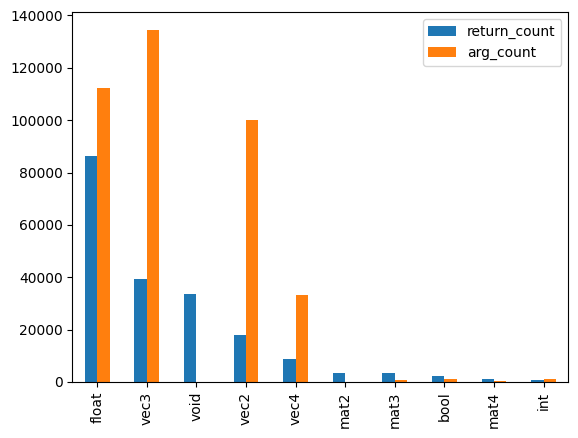

In [16]:
counts.head(10).plot(kind="bar")

In [17]:
counts.to_csv("type_freqs.csv")

In [ ]:
func_df["date"] = pd.to_datetime(func_df["date"], unit="s")
func_df["date"].dt.year.value_counts().sort_index().plot(kind="bar")

In [ ]:
# inspection for length
# show the ids for the longest image_codes
func_df.sort_values("image_code", key=lambda x: x.str.len(), ascending=False).head(10)["id"]
# Stack v2 filters: 100k rows, https://github.com/go-enry/go-enry (is_generated), less than 25% of alphabetic characters, encoded, 
# https://www.shadertoy.com/view/NstGDM (contains a neural network in the code, don't want that)


# func_df["comment"].apply(len).describe(percentiles=[.5, .75, .9, .95, .99])

In [ ]:
combined_df.sort_values(by="date", ascending=True).drop_duplicates("author")["date"].dt.year.value_counts().sort_index()#.plot.bar(alpha=0.3, color="red")
# combined_df.sort_values(by="date", ascending=False).drop_duplicates("author")["date"].dt.year.value_counts().sort_index()#.plot.bar(alpha=0.3, color="blue")

In [ ]:
# Shaders per year, in the combined verison... will get published to API instead.
# all_combined_df["date"] = pd.to_datetime(all_combined_df["date"].astype(int), unit="s") # this should only be run once.
all_combined_df["date"].dt.year.value_counts().sort_index()#.plot(kind="bar", title="shaders per year")

In [ ]:
all_combined_df["license"].value_counts()/len(all_combined_df)

In [ ]:
# check for the percentage of alphabetic characters in the whole code.
api_df[api_df["image_code"].apply(lambda x: sum(c.isalpha() for c in x) / len(x)) < .25][["id"]]#, "comment", "header"]]

In [ ]:
# extract the shader_ids that are left in the end to run tests just on them.
# with open("data/ids/v0-3.txt", "w", encoding="utf-8") as f:
    # f.write("\n".join(func_df["id"].unique().tolist()))

In [ ]:
print(func_df["id"].nunique()) # our 719 functions are just from 290 programs?
func_df["header"].str.split(" ").apply(lambda x: x[0]).value_counts()
# func_df["header"].str.startswith("void").sum()

In [ ]:
# some temporary columns
all_funcs["function"] = all_funcs["header"] + all_funcs["body"]
func_df["function"] = func_df["header"] + func_df["body"]
func_df["function_frequency"] = all_funcs["function"].value_counts()[func_df["function"]].values
func_df["header_frequency"] = all_funcs["header"].value_counts()[func_df["header"]].values
func_df

In [ ]:
# drop some columns we don't need in the dataset
clean_func_df = func_df.drop(columns=["function", "docstring", "needed"])
clean_func_df

In [ ]:
# maybe something to show which kind of shaders are easy/simple?
# the common tags in our dataset are 2d (73 out of 394), sdf (61), 3d (47), distance (39) etc?
# according to the full dataset, our filters have blindspots in "fractal", "raymarching", "noise", "procedural"
from collections import Counter
print("all:", end="")
all_tags = []
for t in all_combined_df["tags"]:
    all_tags.extend(t)
print(len(all_tags))
tag_counts = Counter(all_tags)
print(tag_counts.most_common(10))
print("eval:", end="")
eval_ids = func_df["id"].tolist()
all_tags = []
for t in all_combined_df[all_combined_df["id"].isin(eval_ids)]["tags"]:
    all_tags.extend(t)
print(len(all_tags))
tag_counts = Counter(all_tags)
print(tag_counts.most_common(10))

In [ ]:
# publishing the v0.3 version with context="comment" and all the filters.
from datasets import Dataset
func_ds = Dataset.from_pandas(clean_func_df)
func_ds = func_ds.remove_columns(['__index_level_0__'])
func_ds
# func_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", commit_message="initial v0.4 with 467", private=False, split="test") # don't easily uncomment again...

In [ ]:
print(func_df["author"].nunique())
func_df["license"].value_counts()

In [ ]:
plot_per_month("license", stretched=False, data=combined_df, legend=True)

In [ ]:
# this is skewed due to duplicates -.-
plot_per_year("id", stretched=False, data=func_df, legend=False)

In [ ]:
# this is recent perfer
plot_per_year("id", stretched=False, data=func_df, legend=False)

In [ ]:
from datasets import load_dataset, disable_caching
# disable_caching()
ref_ds = load_dataset("Vipitis/Shadereval-experiments-dev", revision="main", split="test")# , download_mode="force_redownload") #might be revision="0.3" eventually.
ref_ds

In [ ]:
# some functions appear multiple times but at most thirce, and a few twice...
# comments appear up to 15 times which is odd, but all this SDF references I think.
import pandas as pd
ref_df = ref_ds.to_pandas()
ref_df["header"].value_counts().head(20)

In [ ]:
for row in ref_ds:
    print(row)
    break

In [ ]:
# all_funcs["id"].nunique() # 27428 shaders/programs
# all_funcs["header"].nunique() # 78256 unique headers
# all_funcs["body"].nunique() # 130948 unique bodies
all_funcs["function"] = all_funcs["header"] + all_funcs["body"]
all_funcs["function"].nunique() # 137308 unique functions

all_funcs["function"].value_counts().head(20)

In [ ]:
# function/header frequency in the eval set.
all_funcs["header"].value_counts()[func_df["header"]].sort_values(ascending=False).plot(ylim=(0,200), xticks=[]) 
all_funcs["body"].value_counts()[func_df["body"]].sort_values(ascending=False).plot(xticks=[])
all_funcs["function"].value_counts()[func_df["function"]].sort_values(ascending=False).plot(xticks=[])

In [ ]:
# unique timestamps per year

df_dates = pd.DataFrame(func_df["date"].unique(), columns=["date"])
df_dates["date"].dt.year.value_counts().sort_index()#.plot(kind="bar")

In [ ]:
# collect all panics
import tempfile
import subprocess
import os
from tqdm.auto import tqdm

_file_template = """
from wgpu_shadertoy import Shadertoy

shader_code = '''{}'''

shader = Shadertoy(shader_code, shader_type="glsl", offscreen=True)

if __name__ == "__main__":
    shader.show()
    shader.snapshot(123.45)
"""

def _run_shader_in_subprocess(shader_code:str, timeout:float=10) -> str:
    """
    writes the shadercode into a temporary file, and tries to run the shader with a snapshot. This will catch any kind of errors or panics. Even the really bad ones.
    a timeout can be specified. But the enumerate adapter is rather slow, so it can take over 5 seconds just to do that on a slow computer. Therefore a timeout in the range of 10 seconds is needed to avoid false detections.
    returns either "ok", "timeout" or "error"
    #TODO: not tested on unix systems, might required a change in the python command to call.
    """
    status = "ok" # default case
    with tempfile.NamedTemporaryFile(mode="w", suffix=".py", delete=False, encoding="utf-8") as f:
        f.write(_file_template.format(shader_code))
        f.flush()
        try:
            p = subprocess.run(["python", f.name], capture_output=True, timeout=timeout) # this might not work as expect on Linux ...
            
        except Exception as e:
            if isinstance(e, subprocess.TimeoutExpired):
                status = "timeout"
            else:
                status = "other validation error"
    
    # cleanup temp file, delete_on_close was only added in Python 3.12?
    os.remove(f.name)
        
    if status == "ok":
        if p.returncode != 0:
            msg = p.stderr.decode("utf-8")
            if "panic" in msg:
                status = "panic"
                print(msg)
            else:
                status = "error"
    return status

# load the full thing?
api_df = load_data("./data/annotated/api")

In [ ]:
# 7 in the first 1578
for row in tqdm(api_df.itertuples()):
    res = _run_shader_in_subprocess(row.image_code)
    if res == "panic":
        print("\n from:", row.id)
        print(res)
        # break

In [ ]:
new_code = """
void mainImage( out vec4 fragColor, in vec2 fragCoord )
{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = fragCoord/iResolution.xy;

    // Time varying pixel color
    vec3 col = 0.5 + 0.5*cos(iTime+uv.xyx+vec3(0,2,4));

    // Output to screen
    fragColor = vec4(col,1.0);
}
"""

new_codes = [new_code] * len(ref_ds)

print(len(new_codes))

In [ ]:
# testing against the new code to make sure it works. expected 1.0 variation and also might take 30 minutes...
import evaluate

shadermatch = evaluate.load("Vipitis/shadermatch") # public

# res = shadermatch.compute(references=ref_ds["image_code"], predictions=new_codes)

In [ ]:
import datasets

loaded_ds = datasets.load_from_disk("./data/prepared/")
loaded_df = loaded_ds.to_pandas()
# loaded_df.drop(columns=["function", "docstring", "needed"], inplace=True)

ref_ds = datasets.load_dataset("Vipitis/Shadereval-experiments-dev", revision="main", split="test")
ref_df = ref_ds.to_pandas()

In [ ]:
# order is still the same
loaded_ds["model_inp"] == ref_ds["model_inp"]

In [ ]:
loaded_df.sort_values("header_frequency", ascending=False).head(10)

In [ ]:
loaded_df.sort_values(by="header_frequency").reset_index(drop=True)[["header_frequency", "function_frequency"]].plot(ylim=(0,200), xticks=[])

In [ ]:
loaded_df[["header_frequency", "function_frequency"]].plot.box(ylim=(0,50))

In [ ]:
loaded_df[loaded_df["header"].duplicated()].sort_values("header").head(10)

In [ ]:
print(loaded_df["model_inp"][320])
print(loaded_df["model_inp"][386])

In [ ]:
import datasets
loaded_df
func_ds = datasets.Dataset.from_pandas(loaded_df)
# func_ds = func_ds.remove_columns(['__index_level_0__'])
func_ds
# func_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", commit_message="adding header_frequency", private=False, split="test") # don't easily uncomment again...

In [ ]:
# make a plot of shaders per year. compare s20k, api and plot the overlap too!
import os
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt

def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    out_df = pd.DataFrame(lines)
    out_df["date"] = pd.to_datetime(out_df["date"].astype(int), unit="s")
    return out_df

all_shaders20k = load_data("./data/annotated")
# all_api = load_data("./data/annotated/api")
print(len(all_shaders20k))
# print(len(all_api))

s20k_ids = {k:v for k,v in all_shaders20k.groupby(all_shaders20k["date"].dt.year)["id"].unique().items()}
print(len(s20k_ids[2021]))


In [ ]:
ids_path = "./data/ids/"
api_ids = {}
for file in os.listdir(ids_path):
    if file.endswith(".txt") and file.startswith("api_"):
        year = int(file.split("_")[1].removesuffix(".txt"))
        with open(os.path.join(ids_path, file), "r", encoding="utf-8") as f:
            api_ids[year] = list(f.read().splitlines())

len(api_ids[2021])

In [ ]:
overlap = {k: len(set(v).intersection(api_ids[k])) for k,v in s20k_ids.items()}
overlap

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(api_ids.keys(), [len(api_ids[k]) for k in api_ids.keys()], label="API", alpha=0.7)
plt.bar(s20k_ids.keys(), [len(s20k_ids[k]) for k in s20k_ids.keys()], label="shaders20k", alpha=0.7, bottom=[-len(s20k_ids[k])+overlap[k] for k in s20k_ids.keys()])
plt.legend()
plt.xticks(list(api_ids.keys()))
# plt.yticks(list(range(-3000, 5000, 1000)))
plt.savefig("../Thesis/report/texs/charts/shaders_per_year.png")
plt.show()